# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Prepare Data

In [2]:
# Load data
seasons = ['2024-25', '2023-24', '2022-23', '2021-22', '2020-21']
data_frames = []

for season in seasons:
    df = pd.read_csv(f'data/nba_boxscores_{season}.csv')
    data_frames.append(df)

data = pd.concat(data_frames, ignore_index=True)

In [3]:
# Sort data based on player and game date
data['gameDate'] = pd.to_datetime(data['gameDate'])

data = data.sort_values('gameDate').reset_index(drop=True)

In [4]:
# Add seconds column
def parse_minutes_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    try:
        # Split by colon
        minutes_part, seconds_part = str(time_str).split(':')
        # Convert minute to float, in case it's like "36.000000"
        minutes = float(minutes_part)
        seconds = int(seconds_part)
        total_seconds = int(minutes * 60 + seconds)
        return total_seconds
    except:
        return None  # if formatting fails
    
data['seconds'] = data['minutes'].apply(parse_minutes_to_seconds)


In [5]:
# Drop rows where player didn't play
data = data[data['seconds'] > 0]

# Feature Engineering

In [6]:
def player_rolling_5(stat):
    data[f'{stat}_rolling_5'] = (
        data.groupby('playerSlug')[stat]
            .transform(lambda x: x.shift().rolling(window=5).mean())
    )

player_stats = ['seconds', 'fieldGoalsAttempted', 'freeThrowsAttempted', 'points', 'offensiveRating', 'turnoverRatio', 'trueShootingPercentage', 'usagePercentage', 'possessions']

for player_stat in player_stats:
    player_rolling_5(player_stat)

In [7]:
def opp_team_rolling_5(stat):
    games = data.drop_duplicates(subset=['gameId', 'teamId'])
    games = games[['gameId', 'teamId', stat]]

    games[f'team_{stat}_rolling_5'] = (
        games.groupby('teamId')[stat]
            .transform(lambda x: x.shift().rolling(window=5).mean())
    )

    merged_df = pd.merge(
        data,
        games,
        left_on=['gameId', 'opp_teamId'],
        right_on=['gameId', 'teamId'],
        how='left'
    )

    merged_df = merged_df.drop(columns=['teamId_y', f'{stat}_y'])

    merged_df = merged_df.rename(columns={
        'teamId_x': 'teamId',
        f'{stat}_x': '{stat}',
        f'team_{stat}_rolling_5': f'opp_{stat}_rolling_5'
    })

    return merged_df

In [8]:
data = opp_team_rolling_5('defensiveRating')

# Model

Test RMSE: 6.19 points


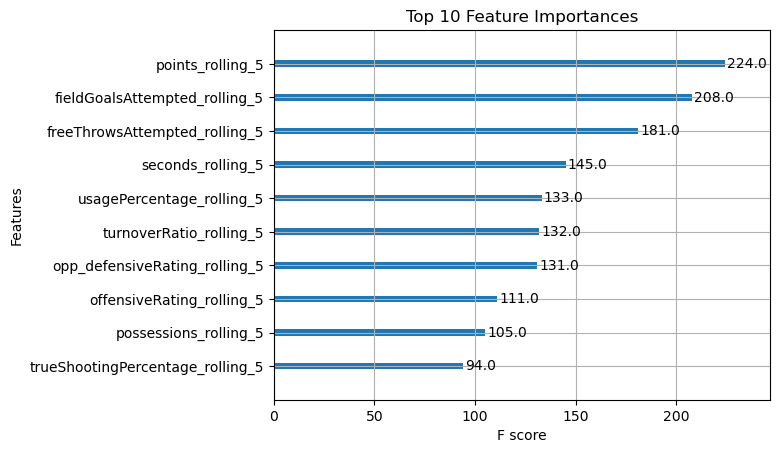

In [9]:
# Select feature to predict
target = "points"

# Select features to train on
features = [
    "seconds_rolling_5",
    "fieldGoalsAttempted_rolling_5",
    "freeThrowsAttempted_rolling_5",
    "points_rolling_5",
    "offensiveRating_rolling_5",
    "turnoverRatio_rolling_5",
    "trueShootingPercentage_rolling_5",
    "usagePercentage_rolling_5",
    "possessions_rolling_5",
    "opp_defensiveRating_rolling_5",
]

# Drop rows with missing data (or impute if you prefer)
data = data.dropna(subset=features + [target])

# Split into features (X) and target (y)
X = data[features]
y = data[target]

# Split train/test by time order to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Train the XGBoost Regressor
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.2f} points")

# Plot Feature Importance
plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()